### Maintenance Prediction Project

### Libraries

In [110]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Off FutureWarnings
import warnings
warnings.filterwarnings('ignore')

#Resampling
from imblearn.over_sampling import SMOTENC
from sklearn.utils import class_weight

#Dimension Reduction
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

# Save model
import pickle
import streamlit as st

### Load dataset

In [15]:
df = pd.read_csv("failures_data.csv")
pd.options.mode.chained_assignment = None
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


### Exploratory Data Analysis

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


#### Check the missing values

In [17]:
df_null = df.isnull().sum().sum()
print(f"Missing value count: {df_null}")

Missing value count: 0


#### Check the duplicate value

In [18]:
df_duplicate = df.duplicated().sum()
print(f"Duplicate value count: {df_null}")

Duplicate value count: 0


#### Describe numeric features

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Target,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0


Columns with possible outliers :
+ Rotational Speed
+ Torque
+ Tool wear

In [20]:
df.Target.value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

#### Failure distribution

In [21]:
df["Failure Type"].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

#### REname for manipulation

In [22]:
rename_columns = {
    'UDI':'ID',
    'Air temperature [K]': 'Air_temperature',
    'Process temperature [K]' : 'Process_temperature',
    'Rotational speed [rpm]' : 'Rotational_speed',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_wear',
    'Product ID' : 'Product_ID',
    'Failure Type': 'Failure_type'    
}
df.rename(rename_columns, axis = 1, inplace = True)

In [36]:
df.sample(10)

,ID,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Target,Failure_type
7484,7485,M22344,M,300.3,311.6,1312,53.4,151,0,No Failure
7521,7522,M22381,M,300.2,311.6,1467,40.7,23,0,No Failure
7163,7164,M22023,M,300.1,310.1,1501,39.3,195,0,No Failure
7200,7201,L54380,L,300.0,309.9,1608,33.4,76,0,No Failure
2638,2639,L49818,L,299.8,309.5,1739,27.5,128,0,No Failure
3250,3251,H32664,H,301.2,309.8,1709,27.0,151,0,No Failure
5681,5682,L52861,L,302.2,311.6,1383,44.3,72,0,No Failure
6478,6479,L53658,L,300.5,309.8,1663,29.1,145,1,No Failure
1506,1507,L48686,L,298.0,308.8,1610,33.7,212,0,No Failure
7858,7859,L55038,L,300.5,311.9,1350,51.7,18,0,No Failure


In [23]:
# Analysing redundance value, count failures on "Target" column
count_failures = (df['Target'] == 1).sum()
print('Number of failures:', count_failures)
# Sum of occurrences of 'Failure_type' other than 'No Failure'
sum_failures = df.loc[(df['Failure_type'] != 'No Failure') & (df['Target'] == 1), 'Failure_type'].count()
print('Sum of failures different of "No Failure":', sum_failures)

Number of failures: 339
Sum of failures different of "No Failure": 330


In [37]:
# Filter the rows with has 1 in the column "Target" and 'No Failure' in the column 'Failure_type'
rows_to_remove = df[(df['Target'] == 1) & (df['Failure_type'] == 'No Failure')]
# Remove this filtered row in the main df
df.drop(rows_to_remove.index, inplace=True)

In [52]:
drop_columns = ["ID","Product_ID","Target"]
df.drop(drop_columns, axis=1 , inplace=True)

In [53]:
df["Failure_type"].value_counts()

Failure_type
No Failure                  9643
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

#### Remove Random Failures

In [54]:
df = df.loc[ df["Failure_type"]!= "Random Failures"]

### Data Visualization

In [55]:
df.sample(5)

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Failure_type
8879,L,298.0,309.2,1527,39.5,85,No Failure
7562,M,300.3,311.1,1350,58.7,130,No Failure
1867,L,298.1,307.9,1502,41.8,79,No Failure
7229,L,299.8,309.8,1749,33.4,153,No Failure
5982,L,300.7,310.8,1486,37.1,186,No Failure


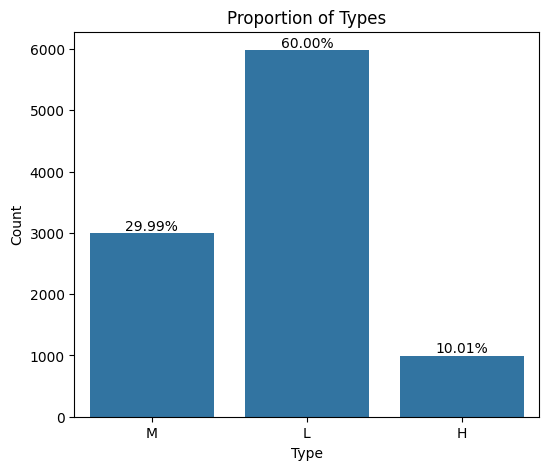

In [60]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=df, x='Type')
plt.title('Proportion of Types')
plt.xlabel('Type')
plt.ylabel('Count')

total = len(df['Type'])
for patch in ax.patches:
    height = patch.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (patch.get_x() + patch.get_width() / 2, height),
                ha='center', va='bottom')
plt.show()

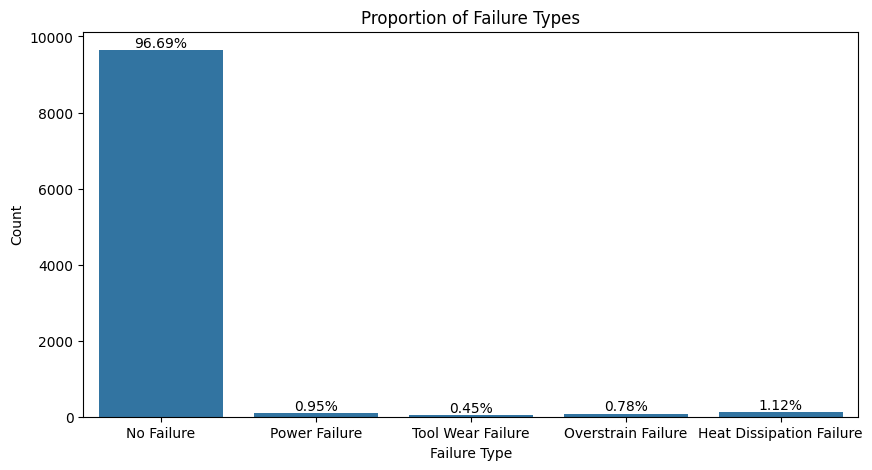

In [64]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x='Failure_type')
plt.title('Proportion of Failure Types')
plt.xlabel('Failure Type')
plt.ylabel('Count')

total = len(df['Failure_type'])
for patch in ax.patches:
    height = patch.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (patch.get_x() + patch.get_width() / 2, height),
                ha='center', va='bottom')
plt.show()

In [65]:
df.sample(4)

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Failure_type
1023,L,296.2,307.3,1881,24.3,40,No Failure
7577,L,300.4,311.2,1530,32.0,169,No Failure
446,L,297.5,308.6,1452,39.0,72,No Failure
7894,M,300.8,312.6,1588,35.6,114,No Failure


In [67]:
NUMERIC_FEATURES = ["Air_temperature", "Process_temperature", "Rotational_speed", "Torque", "Tool_wear"]
CATEGORICAL_FEATURES = ["Type"]

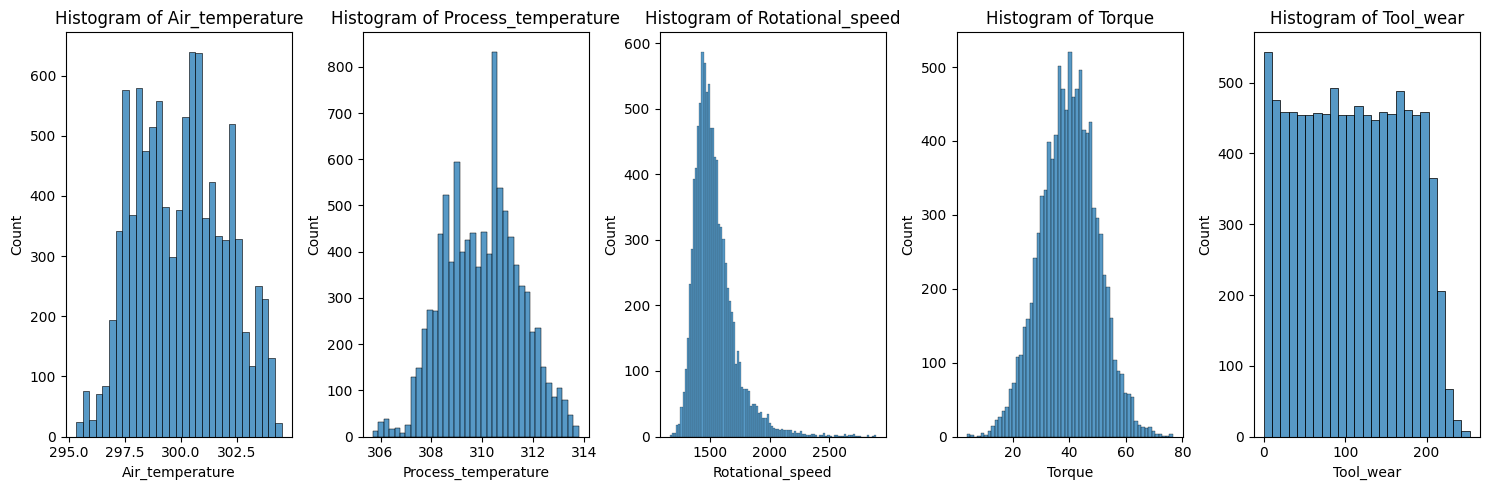

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

for i,feature in enumerate(NUMERIC_FEATURES):
    sns.histplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f"Histogram of {feature}")

plt.tight_layout()
plt.show()


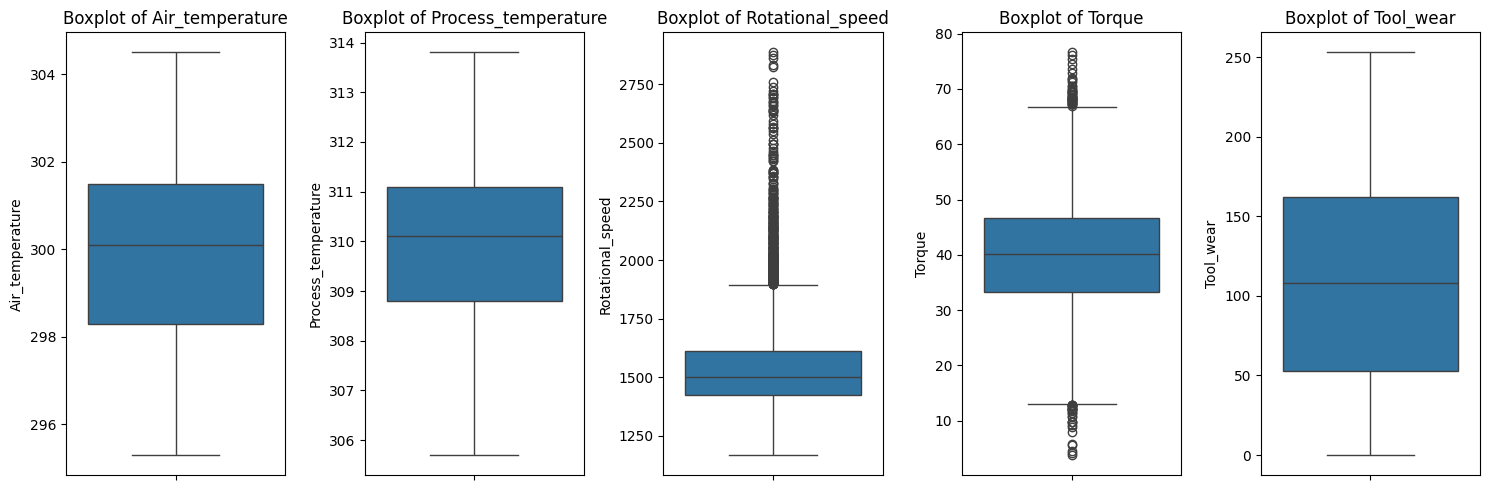

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

for i, feature in enumerate(NUMERIC_FEATURES):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

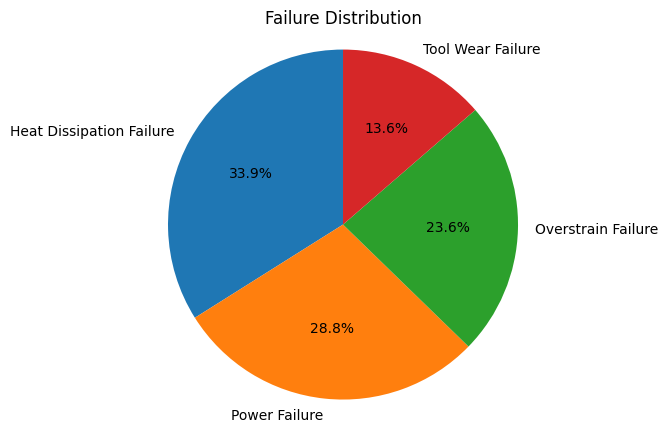

In [74]:
df_failure_type = df.loc[ df["Failure_type"]!= "No Failure"]

pieces = df_failure_type["Failure_type"].value_counts()

plt.figure(figsize=(6,5))
plt.pie(pieces, labels= pieces.index, autopct="%1.1f%%", startangle=90)
plt.axis("equal")
plt.title("Failure Distribution")
plt.show()

<Axes: >

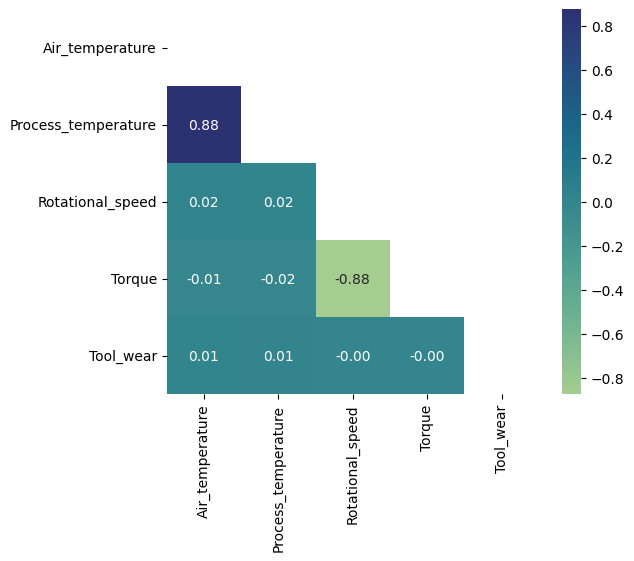

In [81]:
corr = df[NUMERIC_FEATURES].corr()
plt.figure(figsize=(6,5))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask, cmap="crest", fmt=".2f")

### Scaling

In [82]:
numeric_pipeline = Pipeline([
    ("numeric_features", StandardScaler())
])

categoric_pipeline = Pipeline([
    ("categoric_features",OneHotEncoder())
])

scaler = ColumnTransformer( transformers=[
    ("num_trans", numeric_pipeline, NUMERIC_FEATURES),
    ("categoric_trans", categoric_pipeline,CATEGORICAL_FEATURES)
])

In [85]:
df_transformed = scaler.fit_transform(df)

encoded_names = scaler.named_transformers_["categoric_trans"].get_feature_names_out(CATEGORICAL_FEATURES)
new_columns = list(NUMERIC_FEATURES) + list(encoded_names)
df_transformed = pd.DataFrame(df_transformed, columns=new_columns)

df_transformed.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_H,Type_L,Type_M
0,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0.0,0.0,1.0
1,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0.0,1.0,0.0
2,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0.0,1.0,0.0
3,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0.0,1.0,0.0
4,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0.0,1.0,0.0


### PCA Analysis

In [86]:
pca = PCA()
pca.fit(df_transformed)

PCA()

In [88]:
exp_var = pca.explained_variance_ratio_
cum_exp_var = exp_var.cumsum()
# cumsum -> cumulative sum

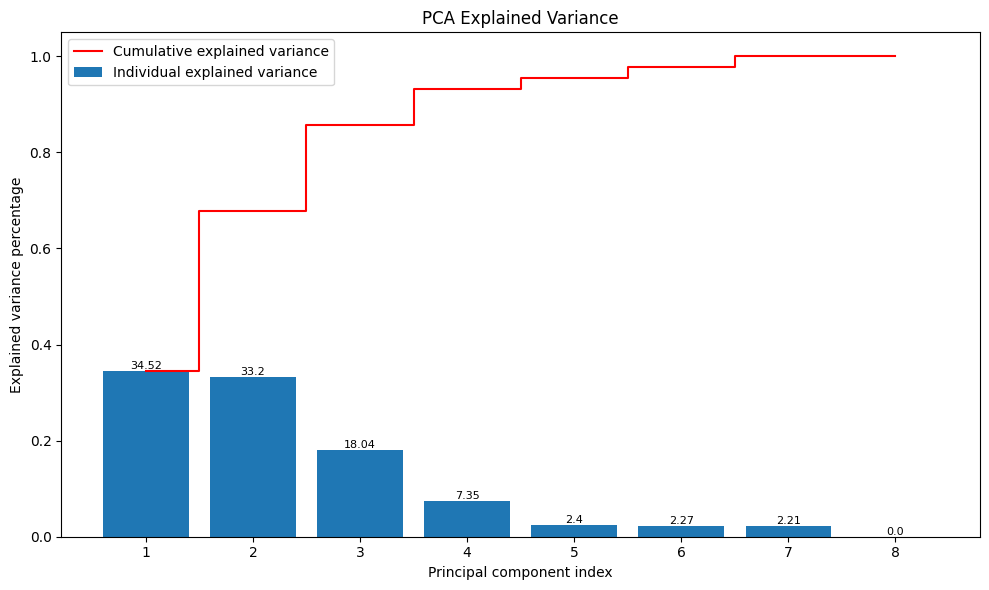

In [89]:
# number of components
pca_components = len(exp_var)

# graphic
plt.figure(figsize=(10,6))
bars = plt.bar(range(1,pca_components+1), exp_var, align="center",label="Individual explained variance")
plt.step(range(1,pca_components+1), cum_exp_var,where="mid",
         label="Cumulative explained variance", color="red")

for bar in bars:
    yval= bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 2),
             va="bottom", ha="center", fontsize =8)

plt.xlabel("Principal component index")
plt.ylabel("Explained variance percentage")
plt.xticks(ticks=list(range(1, pca_components+1)))
plt.title("PCA Explained Variance")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Modeling

In [90]:
def get_metrics(y_true,y_pred):
    f1_scores_per_class = f1_score(y_true,y_pred,average=None)

    dict_metrics = {
        "Accuracy" : accuracy_score(y_true,y_pred),
        "Balanced Accuracy" : balanced_accuracy_score(y_true, y_pred),
        "Macro Recall" : recall_score(y_true, y_pred, average="macro"),
        "Macro Precision" : precision_score(y_true, y_pred, average="macro"),
        "Macro F1" : f1_score(y_true, y_pred, average="macro"),
        "F1 Scores per Class" : f1_scores_per_class
    }
    return dict_metrics

#### Train Test Split

In [92]:
X= df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y = df["Failure_type"]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2, stratify=y)

#### Model with PCA and class_weight

In [93]:
pip_model_pca = Pipeline(steps=[
    ("preprocessor", scaler),
    ("pca", PCA(n_components=4)),
    ("model", RandomForestClassifier(random_state=2024))
])

# fitting
weights = class_weight.compute_sample_weight(class_weight="balanced", y= y_train)
pip_model_pca.fit(X_train, y_train,model__sample_weight = weights)

y_pred = pip_model_pca.predict(X_test)

metrics = get_metrics(y_test,y_pred)

In [94]:
metrics

{'Accuracy': 0.9709273182957393,
 'Balanced Accuracy': 0.2946172248803828,
 'Macro Recall': 0.2946172248803828,
 'Macro Precision': 0.7941620533467539,
 'Macro F1': 0.3435200071057424,
 'F1 Scores per Class': array([0.08695652, 0.98518897, 0.54545455, 0.1       , 0.        ])}

#### Model without PCA and with class_weight

In [95]:
pip_model_no_pca = Pipeline(steps=[
    ("preprocessor", scaler),
    ("model", GradientBoostingClassifier(random_state=2024))
])
weights = class_weight.compute_sample_weight(class_weight="balanced", y= y_train)
pip_model_no_pca.fit(X_train,y_train,model__sample_weight = weights)

y_pred= pip_model_no_pca.predict(X_test)

metrics= get_metrics(y_test, y_pred)

metrics

{'Accuracy': 0.9543859649122807,
 'Balanced Accuracy': 0.7984187561958291,
 'Macro Recall': 0.7984187561958291,
 'Macro Precision': 0.5891624809783378,
 'Macro F1': 0.6494354953840297,
 'F1 Scores per Class': array([0.78571429, 0.97626582, 0.57894737, 0.75      , 0.15625   ])}

#### Model without PCA and with SMOTE-NC

In [99]:
categorical_features_indices = [i for i, feature in enumerate(NUMERIC_FEATURES + CATEGORICAL_FEATURES) 
                                if feature in CATEGORICAL_FEATURES]

pip_model_smotenc = ImbPipeline(steps=[
    ("preprocessor", scaler),
    ("smotenc", SMOTENC(categorical_features=categorical_features_indices,random_state=42)),
    ("model", GradientBoostingClassifier(random_state=42))
])

pip_model_smotenc.fit(X_train, y_train)

y_pred = pip_model_smotenc.predict(X_test)

metrics = get_metrics(y_test, y_pred)

metrics

{'Accuracy': 0.9478696741854636,
 'Balanced Accuracy': 0.8551051358307641,
 'Macro Recall': 0.8551051358307641,
 'Macro Precision': 0.580598694230544,
 'Macro F1': 0.6617230015122039,
 'F1 Scores per Class': array([0.8       , 0.97241379, 0.68292683, 0.72340426, 0.12987013])}

#### GridSearchCV

In [100]:
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', scaler),
    ('model', GradientBoostingClassifier(random_state=42))
])

weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_pca.fit(X_train, y_train, model__sample_weight = weights)

params ={
    'model': [
        LogisticRegressionCV(max_iter=200, random_state=42),
        RandomForestClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42),
        DummyClassifier()
    ],
}

grid = GridSearchCV(pip_model_no_pca,params, cv=3, scoring='f1_macro',n_jobs=1, verbose=1)
grid.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_trans',
                                                                         Pipeline(steps=[('numeric_features',
                                                                                          StandardScaler())]),
                                                                         ['Air_temperature',
                                                                          'Process_temperature',
                                                                          'Rotational_speed',
                                                                          'Torque',
                                                                          'Tool_wear']),
                                                                        ('categoric_trans',
                                                                         Pipeline(steps=[('categoric_features',
                                                                                          OneHotEncoder())]),
                                                                         ['Type'])])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=1,
             param_grid={'model': [LogisticRegressionCV(max_iter=200,
                                                        random_state=42),
                                   RandomForestClassifier(random_state=42),
                                   GradientBoostingClassifier(random_state=42),
                                   DummyClassifier()]},
             scoring='f1_macro', verbose=1)

In [101]:
results = pd.DataFrame(grid.cv_results_)
best_model_index = results['mean_test_score'].idxmax()
best_model_params = results.loc[best_model_index, 'params']

print('Best model:')
print(best_model_params)

Best model:
{'model': GradientBoostingClassifier(random_state=42)}


#### Tuning

In [123]:
fine_tune_params = {
    'model__n_estimators' : [50,100,200, 300, 400, 500],
    'model__max_depth' : [None, 5, 10, 15, 20, 25]
}

fine_tune_grid = GridSearchCV(pip_model_no_pca, fine_tune_params, cv=3, scoring='f1_macro',n_jobs=1, verbose = 1)
fine_tune_grid.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_trans',
                                                                         Pipeline(steps=[('numeric_features',
                                                                                          StandardScaler())]),
                                                                         ['Air_temperature',
                                                                          'Process_temperature',
                                                                          'Rotational_speed',
                                                                          'Torque',
                                                                          'Tool_wear']),
                                                                        ('categoric_trans',
                                                                         Pipeline(steps=[('categoric_features',
                                                                                          OneHotEncoder())]),
                                                                         ['Type'])])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=1,
             param_grid={'model__max_depth': [None, 5, 10, 15, 20, 25],
                         'model__n_estimators': [50, 100, 200, 300, 400, 500]},
             scoring='f1_macro', verbose=1)

In [131]:
fine_tuned_results = pd.DataFrame(fine_tune_grid.cv_results_)
fine_tuned_best_index = fine_tuned_results['mean_test_score'].idxmax()
fine_tuned_best_params = fine_tuned_results.loc[fine_tuned_best_index,'params']

print("Best fine-tuned model parameters:")
print(fine_tuned_best_params)

Best fine-tuned model parameters:
{'model__max_depth': 5, 'model__n_estimators': 200}


In [132]:
tuned_model = fine_tune_grid.best_estimator_
y_pred = tuned_model.predict(X_test)

get_metrics(y_test, y_pred)

{'Accuracy': 0.9829573934837093,
 'Balanced Accuracy': 0.6405461155716947,
 'Macro Recall': 0.6405461155716947,
 'Macro Precision': 0.6675660462440328,
 'Macro F1': 0.651900662919165,
 'F1 Scores per Class': array([0.86956522, 0.99147066, 0.62068966, 0.77777778, 0.        ])}

#### Confusion matrix

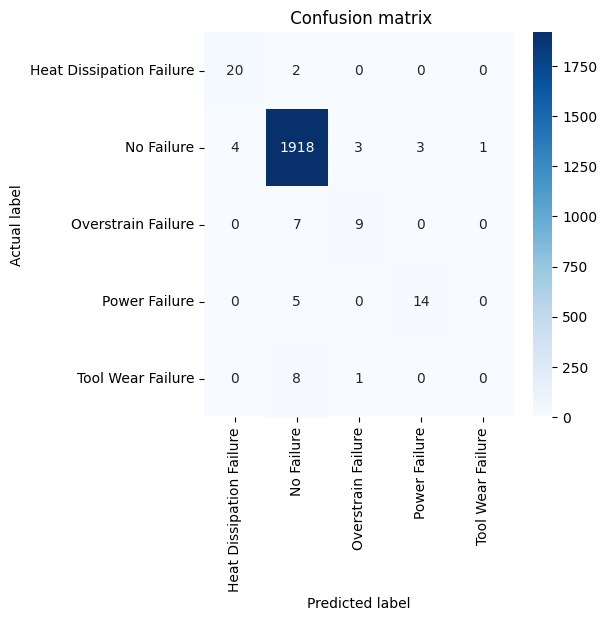

In [134]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels= np.unique(y_test),
            yticklabels= np.unique(y_pred))

plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title(" Confusion matrix")
plt.show()

### Deployment

In [135]:
with open('model/model.pkl', 'wb') as model_file:
    pickle.dump(tuned_model, model_file)